# Integrating Multi-Modal Spatially-Resolved Technologies with LIANA+

Here, we apply of LIANA+ on a spatially-resolved metabolite-transcriptome dataset from a recent murine Parkinson’s disease model [Vicari et al., 2023](https://www.nature.com/articles/s41587-023-01937-y). 
We demonstrate LIANA+'s utility in harmonizing spatially-resolved transcriptomics and MALDI-MSI data to unravel metabolite-mediated interactions and the molecular mechanisms of dopamine regulation in the striatum.

Two particular challenges with this data are:
- The unaligned spatial locations of the two omics technologies
- The untargeted nature of the MALDI-MSI data, which results in a large number of features with unknown identities. Only few of which were previously identified as specific metabolites.

Here, we show untargeted modelling of known and unknown metabolite peaks and their spatial relationships with transcriptomics data. Specifically, we use a multi-view modelling strategy [MISTy](https://liana-py.readthedocs.io/en/latest/notebooks/misty.html) to decipher global spatial relationships of metabolite peaks with cell types and brain-specific receptors. Then, we use LIANA+'s [local metrics](https://liana-py.readthedocs.io/en/latest/notebooks/bivariate.html) to pinpoint the subregions of interaction. 

We also show strategies to enable spatial multi-omics analysis from diverse omics technologies with unaligned locations and observations.

In [1]:
from performance_monitor import PerformanceMonitor
monitor = PerformanceMonitor()
monitor.start()

In [2]:
import numpy as np
import liana as li
import mudata as mu
import scanpy as sc

from matplotlib import pyplot as plt
from adjustText import adjust_text

In [3]:
# set global figure parameters
kwargs = {'frameon':False, 'size':1.5, 'img_key':'lowres'}

## Obtain and Examine the Data

First, we obtain the a single slide from the dataset. This slide has already been preprocessed, including filtering and normalisation.
We have log1p transformed the RNA-seq data and total-ion count normalised the MALDI-MSI data.

We have also **pre-aligned** the images from the two technologies, though the observations are not aligned - an issue that we will address in this notebook.
For image and coordinate transformations, we refer the users to [SpatialData](https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks.html) or [stAlign](https://jef.works/STalign/overview.html#input-data).

We have additionally deconvoluted the cell types in the RNA-seq data using [Tangram](https://github.com/broadinstitute/Tangram).


So, in total we have three modalities: the MALDI-MSI data, the RNA-seq data, and the cell type data:

In [4]:
# let's download the data
rna = sc.read("sma_rna.h5ad", backup_url="https://figshare.com/ndownloader/files/44624974?private_link=4744950f8768d5c8f68c")
msi = sc.read("sma_msi.h5ad", backup_url="https://figshare.com/ndownloader/files/44624971?private_link=4744950f8768d5c8f68c")
ct = sc.read("sma_ct.h5ad", backup_url="https://figshare.com/ndownloader/files/44624968?private_link=4744950f8768d5c8f68c")

In [5]:
# and create a MuData object
mdata = mu.MuData({'rna':rna, 'msi':msi, 'ct':ct})
mdata

MuData object with n_obs × n_vars = 6041 × 17782
  3 modalities
    rna:	3036 x 16486
      obs:	'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
      uns:	'lesion_colors', 'log1p', 'region_colors', 'spatial'
      obsm:	'spatial'
      layers:	'counts'
    msi:	3005 x 1248
      obs:	'x', 'y', 'array_row', 'array_col', 'leiden', 'n_counts', 'index_right', 'region', 'lesion'
      var:	'mean', 'std', 'mz', 'max_intensity', 'mz_raw', 'annotated'
      uns:	'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'spatial'
      obsm:	'X_pca', 'spatial'
      varm:	'PCs'
      layers:	'raw'
      obsp:	'connectivities', 'distances'
    ct:	3036 x 48
      obs:	'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'uniform_density', 'rna_count_based_density'
      uns:	'lesion_colors', 'log1p', 'overlap_genes', 'region_colors', 'spatial', 'training_genes'
      obsm:	'spatial', 'tangram_ct_pred'

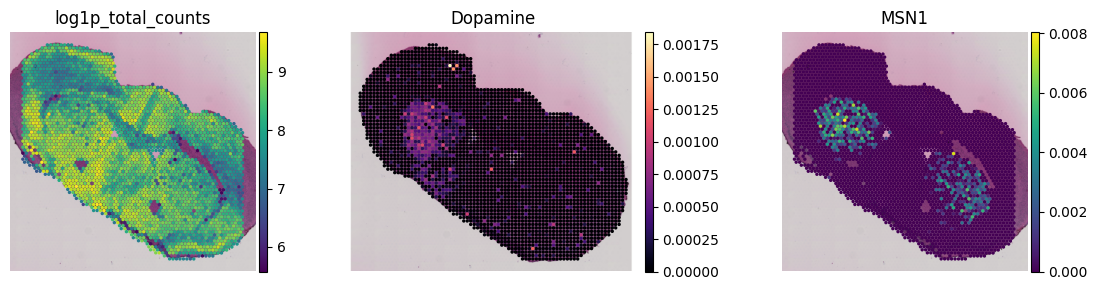

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

sc.pl.spatial(rna, color='log1p_total_counts', ax=axes[0], **kwargs, show=False)
sc.pl.spatial(msi, color='Dopamine', cmap='magma', ax=axes[1], **kwargs, show=False)
sc.pl.spatial(ct, color='MSN1', cmap='viridis', ax=axes[2], **kwargs, show=False)

fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()

If you look closely here, you will notice that the metabolite locations are not aligned in a grid-like manner as the 10X Visium Data. We will address this in the next steps.

## Experimental Design

Of note, mice in this data were subjected to unilateral 6-hydroxydopamine-induced lesions in one hemisphere while the other remained intact. 
These 6-Hydroxydopamine-induced lesions selectively destroy substantia nigra-originated dopaminergic neurons, thereby impairing dopamine-mediated regulatory mechanisms of the striatum - an area of the brain crucial for movement coordination.

Along with annotations of the lesioned and intact hemispheres, we also have annotations for the striatum:


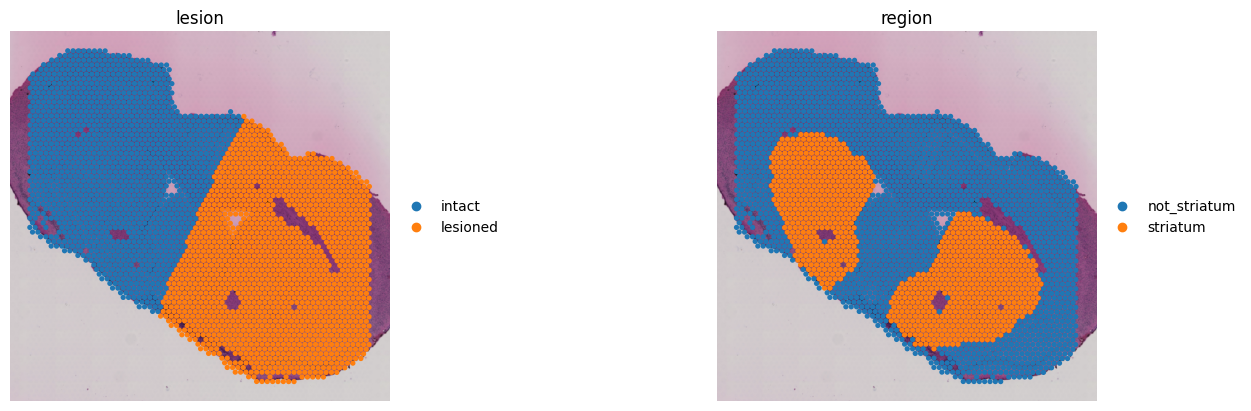

In [7]:
sc.pl.spatial(rna, color=['lesion', 'region'], **kwargs, wspace=0.25)

## Multi-view Modelling Metabolite Intensities

Next, we will model the metabolite intensities jointly using cell types and brain specific receptors as predictors.

### Remove features with little-to-no variation
Done to avoid fitting noisy readouts in our model

In [8]:
sc.pp.highly_variable_genes(rna, flavor='cell_ranger', n_top_genes=1000)
sc.pp.highly_variable_genes(msi, flavor='cell_ranger', n_top_genes=120)
ct.var['cv'] = ct.X.A.var(axis=0) / ct.X.A.mean(axis=0)
ct.var['highly_variable'] = ct.var['cv'] > np.percentile(ct.var['cv'], 20)

In [9]:
msi = msi[:, msi.var['highly_variable']]
rna = rna[:, rna.var['highly_variable']]
ct = ct[:, ct.var['highly_variable']]

Note that we use simple coefficient of variation and highly-variable gene functions, but one may easily replace this step with e.g. the spatially-informed Moran's I from [Squidpy](https://squidpy.readthedocs.io/en/stable/).

### Additional processing steps
Scale the intensities and cap the max value

In [10]:
sc.pp.scale(msi, max_value=5)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.


Obtain brain-specific metabolite-receptor interactions

In [11]:
metalinks = li.rs.get_metalinks(tissue_location='Brain',
                                biospecimen_location='Cerebrospinal Fluid (CSF)',
                                )
metalinks['gene_symbol'] = metalinks['gene_symbol'].str.title()

Intersect the RNA modality with the receptors

In [12]:
receptors = np.intersect1d(metalinks['gene_symbol'].unique(), rna.var_names)
rec = rna[:, receptors].copy()

### Compute Spatial Proximies for the Multi-view Model

We use the metabolite modality as reference to which we align the other modalities.
We use the `spatial_neighbors` function to compute the spatial proximity from cell types and brain-specific receptors to the metabolite intensities.

In [13]:
bandwidth = 1000
cutoff = 0.1
# distances of metabolties to RNA
reference = mdata.mod["msi"].obsm["spatial"]

In [14]:
li.ut.spatial_neighbors(ct, bandwidth=bandwidth, cutoff=cutoff, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)
li.ut.spatial_neighbors(rec, bandwidth=bandwidth, cutoff=cutoff, spatial_key="spatial", reference=reference, set_diag=False, standardize=False)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


### Construct and Run the Multi-view model

Specifically, we use the metabolite intensities as the intraview - i.e. targets of prediction. While the cell types and brain-specific receptors are the extraview - i.e. spatially-weighted predictors.

In [15]:
# MISTy
mdata.update_obs()
misty = li.mt.MistyData({"intra": msi, "receptor": rec, "ct": ct}, enforce_obs=False, obs=mdata.obs)
misty

view intra is not a csr_matrix. Converting to csr_matrix


MuData object with n_obs × n_vars = 6041 × 313
  obs:	'rna:in_tissue', 'rna:array_row', 'rna:array_col', 'rna:x', 'rna:y', 'rna:lesion', 'rna:region', 'rna:n_genes_by_counts', 'rna:log1p_n_genes_by_counts', 'rna:total_counts', 'rna:log1p_total_counts', 'rna:pct_counts_in_top_50_genes', 'rna:pct_counts_in_top_100_genes', 'rna:pct_counts_in_top_200_genes', 'rna:pct_counts_in_top_500_genes', 'rna:total_counts_mt', 'rna:log1p_total_counts_mt', 'rna:pct_counts_mt', 'rna:n_genes', 'rna:n_counts', 'msi:x', 'msi:y', 'msi:array_row', 'msi:array_col', 'msi:leiden', 'msi:n_counts', 'msi:index_right', 'msi:region', 'msi:lesion'
  var:	'highly_variable'
  3 modalities
    intra:	3005 x 120
      obs:	'x', 'y', 'array_row', 'array_col', 'leiden', 'n_counts', 'index_right', 'region', 'lesion'
      var:	'mean', 'std', 'mz', 'max_intensity', 'mz_raw', 'annotated', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'hvg'
      obsm:	'X_pca', 'spatial'
      varm:	'PCs'
      layers:	'raw'
      obsp:	'connectivities', 'distances'
    receptor:	3036 x 155
      obs:	'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'lesion_colors', 'log1p', 'region_colors', 'spatial', 'hvg'
      obsm:	'spatial', 'spatial_connectivities'
      layers:	'counts'
    ct:	3036 x 38
      obs:	'in_tissue', 'array_row', 'array_col', 'x', 'y', 'lesion', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'uniform_density', 'rna_count_based_density'
      var:	'cv', 'highly_variable'
      uns:	'lesion_colors', 'log1p', 'overlap_genes', 'region_colors', 'spatial', 'training_genes'
      obsm:	'spatial', 'tangram_ct_pred', 'spatial_connectivities'

By using the metabolite modality as a reference, we can now predict the metabolite intensities from the spatially-weighted cell types and brain-specific receptors.

Specifically, we do so, by modelling the lesioned and intact hemispheres separately - enabled via the `maskby` parameter.
This masking procedure, simply masks the observations according to the `lesion` annotations, following spatially-weighting the extra views.  

In [16]:
misty(model="linear", verbose=True, bypass_intra=True, maskby='lesion')

Now learning: 1048.38 masked by lesioned: 100%|██████████| 120/120 [02:18<00:00,  1.15s/it]


We can see that in the intact hemisphere there are several metabolites peaks which are relatively well predicted (R2 > 0.5), and among them are Dopamine and 3-Methoxytyramine (3-MT).
Of note, while we don't focus on the unannotated metabolite peaks, we can see that some of them are also well predicted. This is a good indication of which metabolite peaks might be of interest for further investigation, and subsequently, identification.

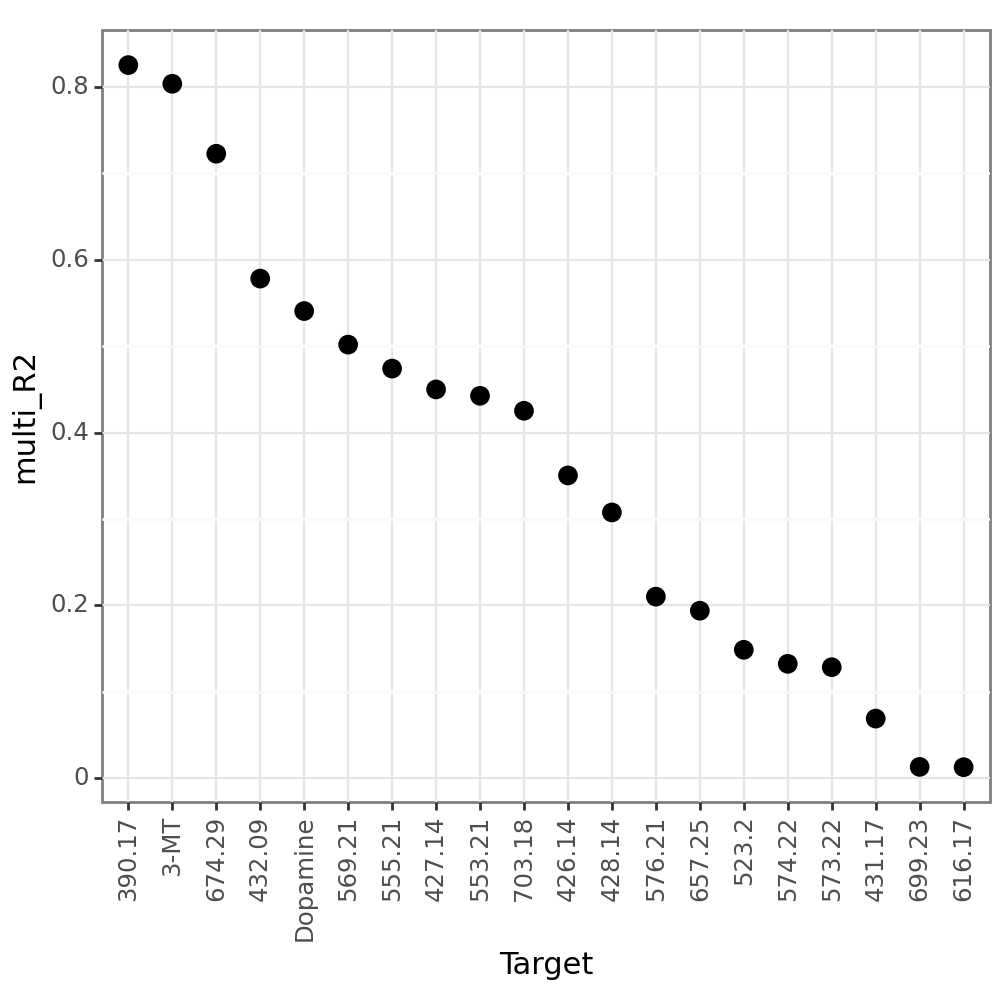

<Figure Size: (500 x 500)>

In [17]:
li.pl.target_metrics(misty, stat='multi_R2', return_fig=True, top_n=20, filter_fun=lambda x: x['intra_group']=='intact')

On the other hand, we don't see those peaks in the lesioned hemisphere, which is consistent with the 6-Hydroxydopamine-induced lesions, and the absence of Dopamine in this hemisphere.

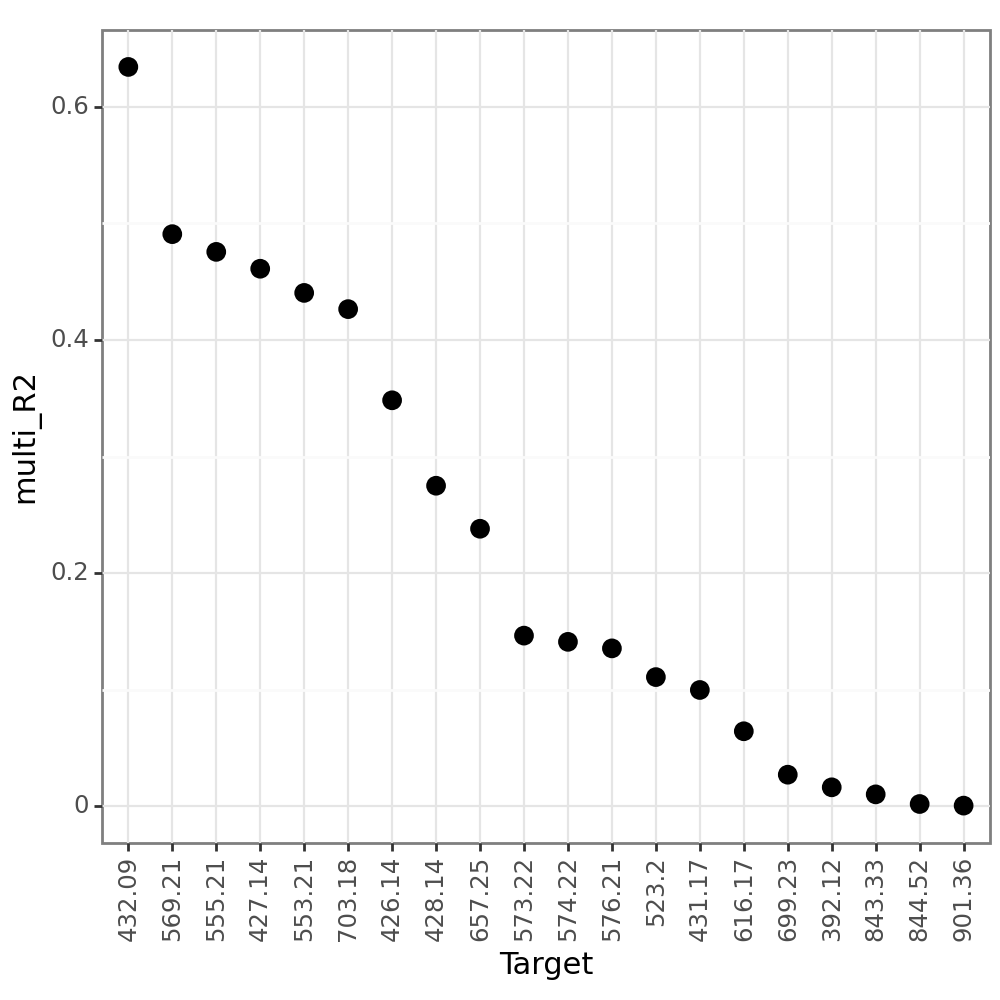

<Figure Size: (500 x 500)>

In [18]:
li.pl.target_metrics(misty, stat='multi_R2', return_fig=True, top_n=20, filter_fun=lambda x: x['intra_group']=='lesioned')

Within the intact hemisphere we can see that in the top predictors of Dopamine are MSN1/2 as well as Drd1/2 receptors. 
MSN1/2 are Medium Spiny Neurons, which are the main cell type in the striatum, and Drd1/2 are Dopamine receptors. This is consistent with the known biology of the striatum, where Dopamine is a key neurotransmitter, and the Drd1/2 receptors are the main receptors for Dopamine in the striatum.

In [19]:
interactions = misty.uns['interactions']

/tmp/ipykernel_368091/2912656372.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


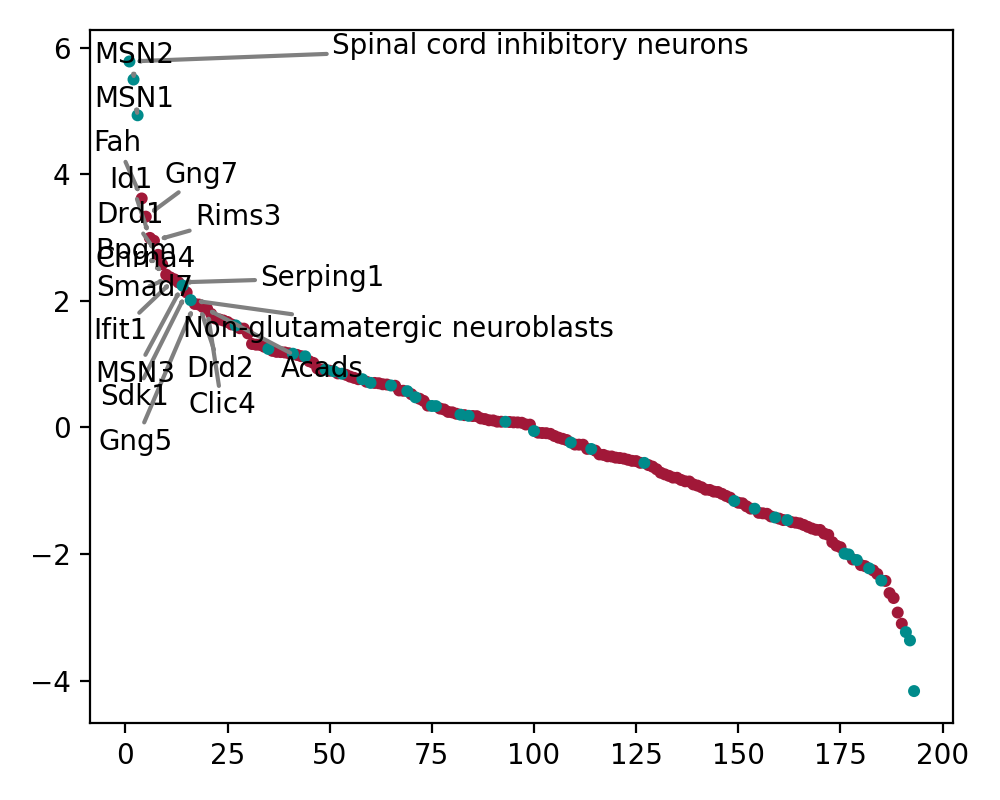

In [20]:
interactions = interactions[(interactions['intra_group'] == 'intact') & (interactions['target'] == 'Dopamine')]
# Create scatter plot
plt.figure(figsize=(5, 4))
# rank rank by abs importances
interactions['rank'] = interactions['importances'].rank(ascending=False)
plt.scatter(interactions['rank'], interactions['importances'], s=11,
            c=interactions['view'].map({'ct': '#008B8B', 'receptor': '#a11838'}))
            
# add for top 10
top_n = interactions[interactions['rank'] <= 20]
texts = []
for i, row in top_n.iterrows():
    texts.append(plt.text(row['rank'], row['importances'], row['predictor'], fontsize=10))
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='grey', lw=1.5))
plt.tight_layout()

## Identifying Local Interactions

Focusing on Dopamine, we can next use LIANA+'s local metrics to identify the subregions of interactions with Drd1/2 receptors and MSN1/2 cells.

While the transformation of spatial locations is done internally by MISTy, we need to transform the metabolite intensities to a grid-like manner, so that we can use the local metrics.
To do so, we use the `interpolate_adata` function, which interpolates one modality to another. Here, we will interpolate the metabolite intensities to the RNA-seq data, so that we can use the spatial locations of the RNA-seq data to identify the local interactions.


In [21]:
metabs = li.ut.interpolate_adata(target=msi, reference=rna, use_raw=False, spatial_key='spatial')

Notice that the Metabolite observations now resemble the grid-like structure of Visium data:

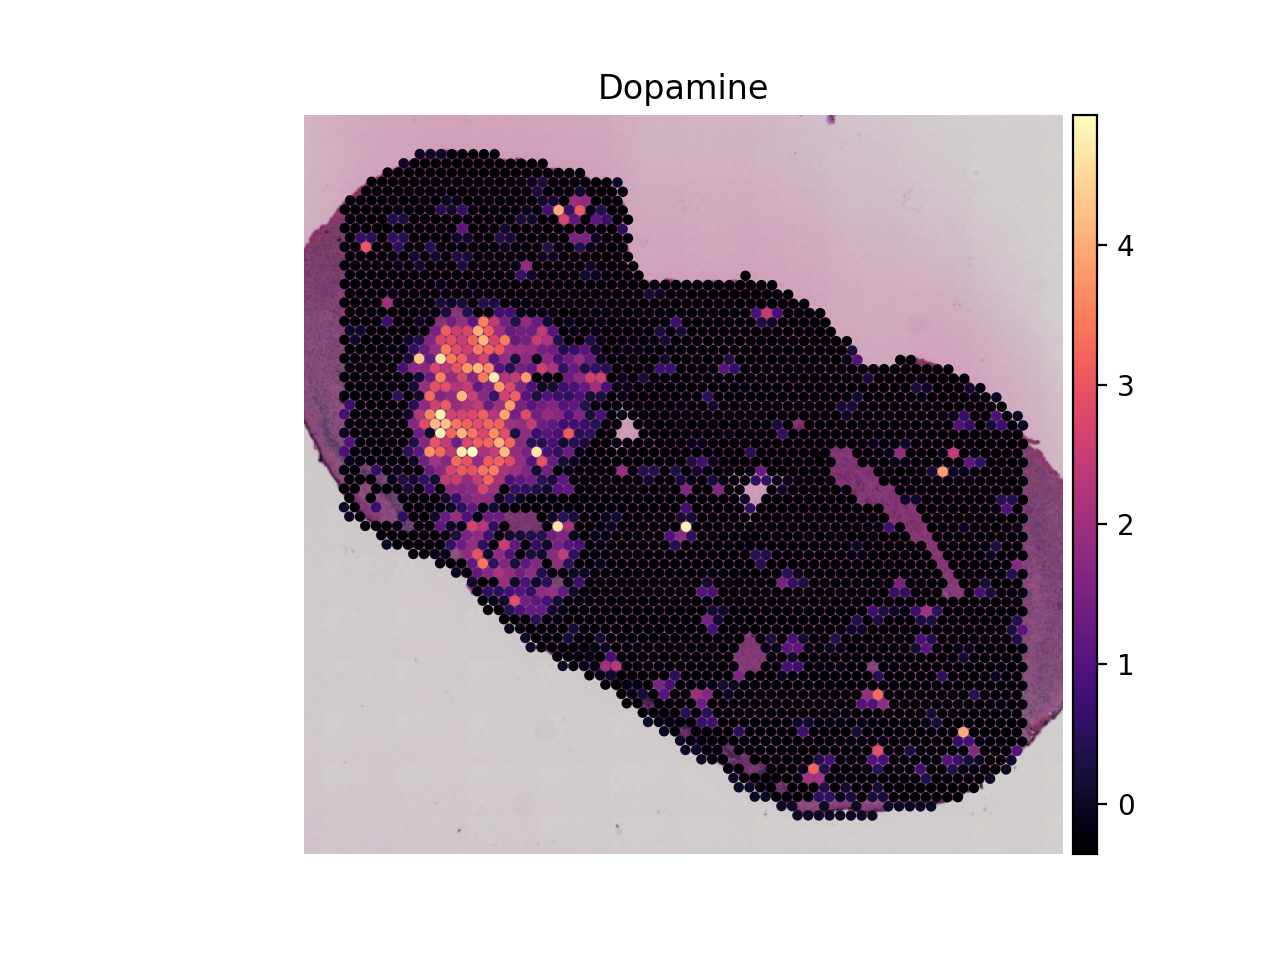

In [22]:
sc.pl.spatial(metabs, color='Dopamine', cmap='magma', **kwargs)

Let's rebuild a MuData object with these updated metabolite intensities

In [23]:
mdata = mu.MuData({'msi': metabs, 'rna':rna, 'deconv':ct}, obsm=rna.obsm, obs=rna.obs, uns=rna.uns)

and now we can again calculate the spatial proximities, but this time without a reference as all observations within the MuData have the same spatial locations.

In [24]:
li.ut.spatial_neighbors(mdata, bandwidth=bandwidth, cutoff=cutoff, set_diag=True)

Let's calculate the local metrics for the Dopamine intensities with and Drd1/2 receptors.

In [25]:
li.mt.bivar(mdata, 
            function_name='cosine',
            x_mod='msi', 
            y_mod='rna',
            x_use_raw=False, 
            y_use_raw=False,
            verbose=True, 
            mask_negatives=True, 
            n_perms=100,
            interactions = metalinks[['metabolite', 'gene_symbol']].apply(tuple, axis=1).tolist(),
            x_transform=sc.pp.scale,
            y_transform=sc.pp.scale,
            mod_added='lr'
            )

Using provided `interactions`.
Using `.X`!


Using `.X`!
Using `.X`!
Converting to sparse csr matrix!


Transforming msi using scale
Transforming rna using scale


100%|██████████| 100/100 [00:05<00:00, 17.55it/s]


Here, we will plot the permutation-based local P-values

... storing 'x' as categorical


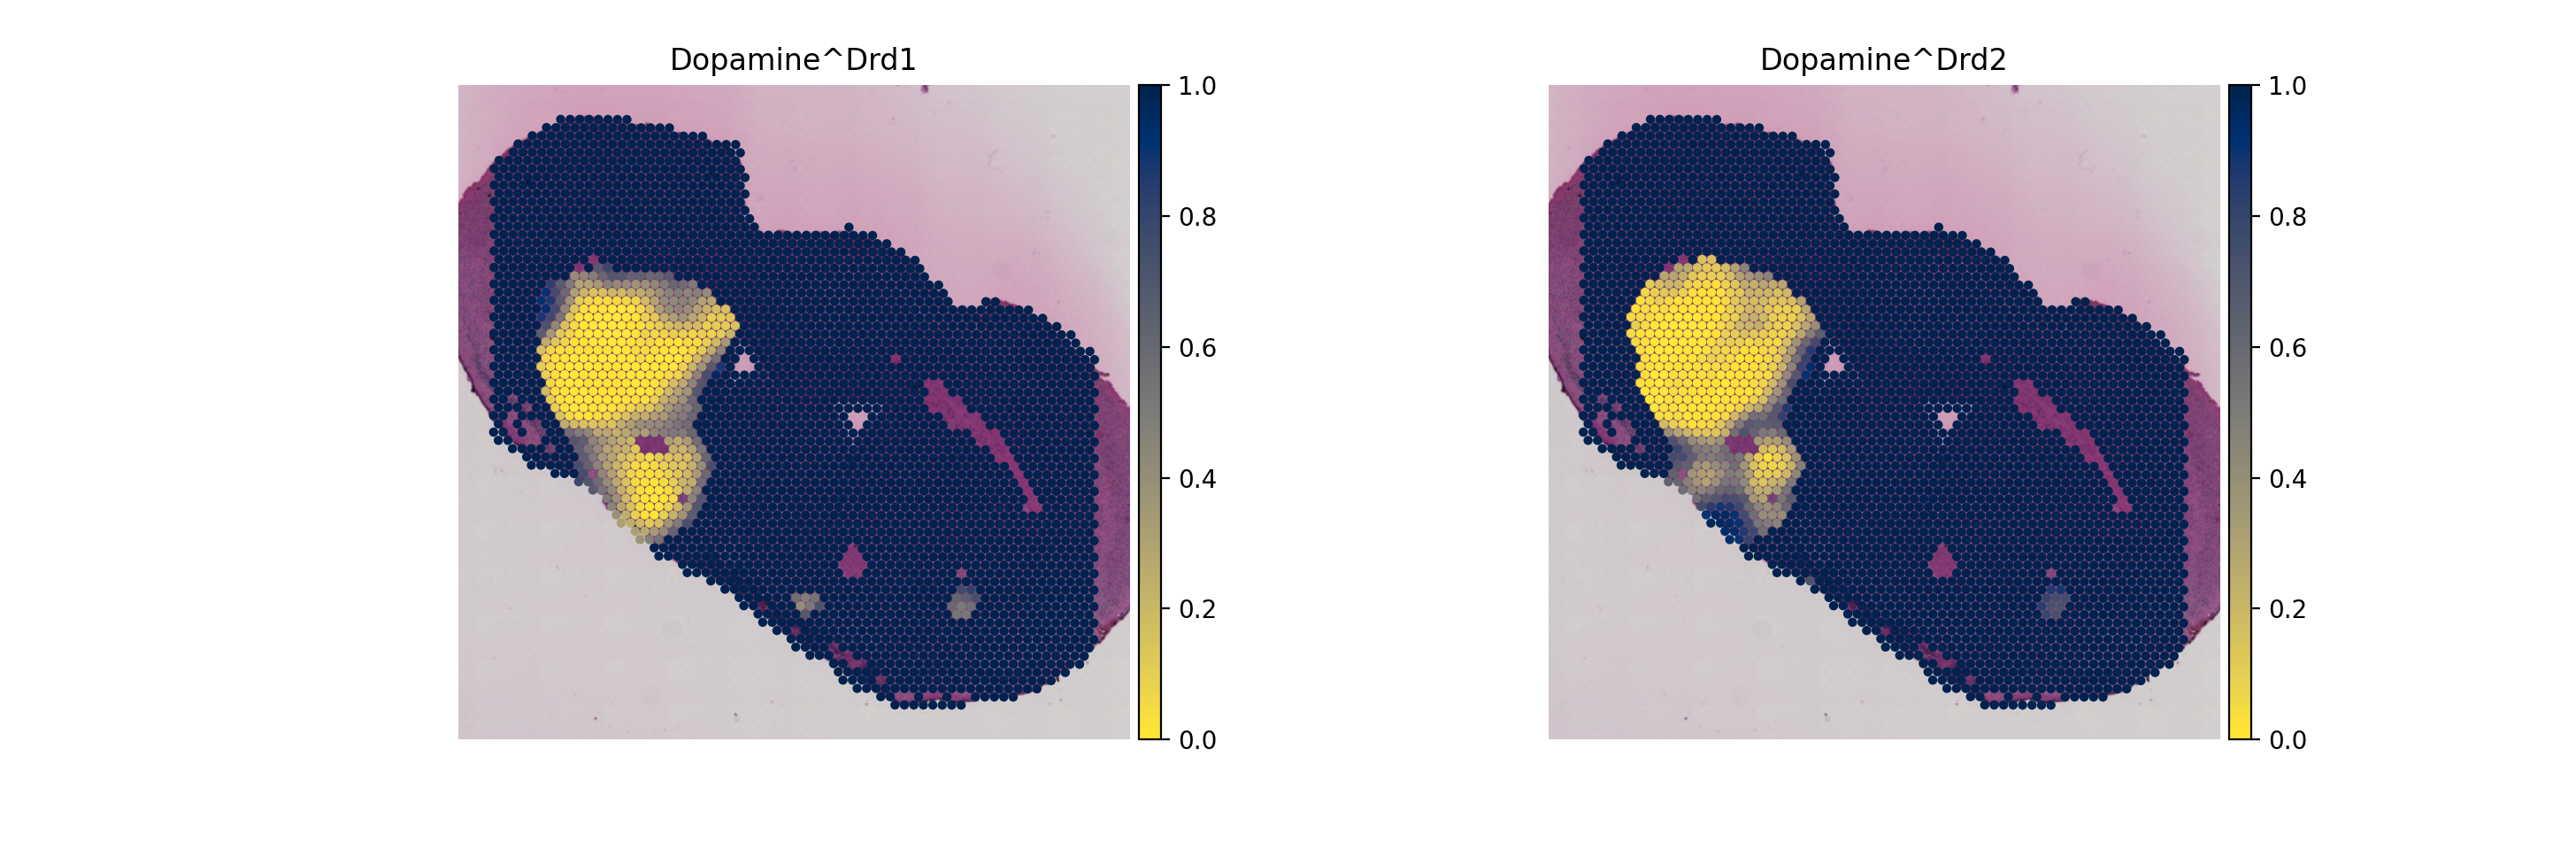

In [26]:
sc.pl.spatial(mdata.mod['lr'], 
              color=['Dopamine^Drd1', 'Dopamine^Drd2'],
              cmap='cividis_r', vmax=1, layer='pvals',
              **kwargs)

We see that interactions with Dopamine as largely anticipated are predominantly located within the Striatum of the intact hemisphere, and are typically absent in the lesioned hemisphere.

In [27]:
monitor.stop()
print(f"Elapsed Time: {monitor.elapsed_time() / 60} minutes")
print(f"Maximum Memory Usage: {monitor.get_max_memory_usage()} MB")

Elapsed Time: 2.6327427784601847 minutes
Maximum Memory Usage: 1013.859375 MB
